In [2]:
import os
import sys

sys.path.append(os.path.abspath('..'))

In [3]:
import matplotlib.pyplot as plt
import torch
import os
import time
import torch.nn as nn
import numpy as np
import torchvision.utils as vutils

from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
from torch import optim
from tqdm import tqdm 

from learnable_priors.models.conv_net import ConvNetPrior, InvConvNetPrior
from nn.nets import MLP, ConvNet, InvConvNet
from data.loaders.image import CelebA, MNIST
from models.bae import BAE
from distributions import DiagonalNormal, ConditionalNormal, ConditionalBernoulli
from samplers import AdaptiveSGHMC, SGHMC
from priors import PriorNormal
from utils import ensure_dir, set_seed, DensityEstimator, inf_loop, save_images_to_npy
from wasserstein_dist import TransformNet, distributional_sliced_wasserstein_distance

In [4]:
# Utility function used to sample from induced functional prior of BAE
def sample_autoencoder_prior(X, encoder_prior, decoder_prior, n_samples):
    samples = []
    
    for _ in range(n_samples):
        sample = encoder_prior.sample(X, 1)
        sample = decoder_prior.sample(sample, 1)
        
        samples.append(sample)
        
    return torch.cat(samples)

In [6]:
SEED = 123

device = 'cuda' if torch.cuda.is_available() else 'cpu'

set_seed(SEED)

data = CelebA(root="../datasets")
train_loader, _, _ = data.get_data_loaders(2000)

x_subset = next(iter(train_loader))


dataset_subset = TensorDataset(x_subset)
dataloader_subset = DataLoader(dataset_subset, batch_size=32, shuffle=True)

# Priors

## Standard Gaussian Prior

In [8]:
# Let initialize the standard Gaussian Prior

set_seed(123)
latent_size = 50

W_prior_params = {'mean_init': 0., 'log_var_init': 0.}
b_prior_params = {'mean_init': 0., 'log_var_init': 0.}

encoder_prior = ConvNetPrior(
    3, latent_size,
    n_channels=[64, 128, 256, 512],
    kernel_sizes=[5, 5, 5, 5],
    strides=[2, 2, 2, 2],
    paddings=[0, 0, 0, 0],
    activation='leaky_relu',
    in_lambda=None,
    W_prior_dist="GaussianDistribution",
    b_prior_dist="GaussianDistribution",
    W_prior_params=W_prior_params,
    b_prior_params=b_prior_params)

decoder_prior = InvConvNetPrior(
    latent_size, 3, n_hiddens=[8*8*512], n_channels=[512, 256, 128],
    kernel_sizes=[5, 5, 4],
    strides=[2, 2, 2],
    paddings=[2, 1, 0],
    activation='leaky_relu',
    mid_lambda=lambda x: x.view(x.shape[0], 512, 8, 8),
    out_lambda=lambda x: torch.sigmoid(x.view(x.shape[0], 3, 64, 64)),
    W_prior_dist="GaussianDistribution",
    b_prior_dist="GaussianDistribution",
    W_prior_params=W_prior_params,
    b_prior_params=b_prior_params)

encoder_prior = encoder_prior.to(device)
decoder_prior = decoder_prior.to(device)

Sample from functional prior induced by the standard Gaussian prior over parameters

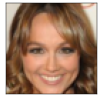

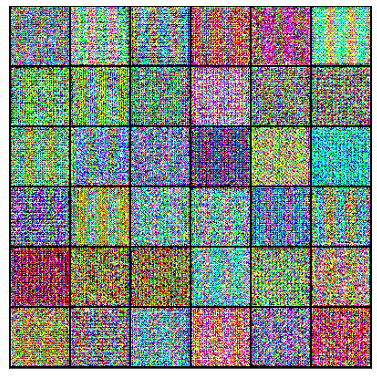

In [11]:
# Given a CelebA input
set_seed(3)

# Visualize the input
data = next(iter(dataloader_subset))
x = data[0].to(device)

grid_img = vutils.make_grid(x[0].view(1, 3, 64, 64).cpu().float(), nrow=1)
fig = plt.figure(figsize=(3, 3), dpi=40)
plt.imshow(grid_img.permute(1, 2, 0).detach().numpy())
plt.xticks([])
plt.yticks([])
plt.show()

# Visualize the samples from the induced functional prior
x_pred = sample_autoencoder_prior(x, encoder_prior, decoder_prior, 36)

grid_img = vutils.make_grid(x_pred[::32].view(x_pred[::32].shape, 3, 64, 64).cpu().float(), nrow=6)
fig = plt.figure(figsize=(8, 8), dpi=60)
plt.imshow(grid_img.permute(1, 2, 0).detach().numpy())
plt.xticks([])
plt.yticks([])
plt.show()

del x_pred
del x
torch.cuda.empty_cache()

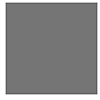

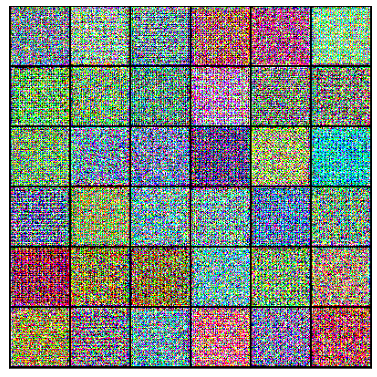

In [12]:
# Given a noisy input
set_seed(3)

# Visualize the input
data = next(iter(dataloader_subset))
x = data[0].to(device)
x = torch.ones_like(x) * (x.mean())
x = x.to(device) 

grid_img = vutils.make_grid(x[0].view(1, 3, 64, 64).cpu().float(), nrow=1)
fig = plt.figure(figsize=(3, 3), dpi=40)
plt.imshow(grid_img.permute(1, 2, 0).detach().numpy())
plt.xticks([])
plt.yticks([])
plt.show()

# Visualize the samples from the induced functional prior
x_pred = sample_autoencoder_prior(x, encoder_prior, decoder_prior, 36)

grid_img = vutils.make_grid(x_pred[::32].view(x_pred[::32].shape, 3, 64, 64).cpu().float(), nrow=6)
fig = plt.figure(figsize=(8, 8), dpi=60)
plt.imshow(grid_img.permute(1, 2, 0).detach().numpy())
plt.xticks([])
plt.yticks([])
plt.show()

del x_pred
del x
torch.cuda.empty_cache()

## Optimized Prior

Load the optimized prior

In [40]:
encoder_prior.load_state_dict(torch.load("../exp/conv_celeba/prior/encoder_prior.pt"))
decoder_prior.load_state_dict(torch.load("../exp/conv_celeba/prior/decoder_prior.pt"))

<All keys matched successfully>

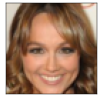

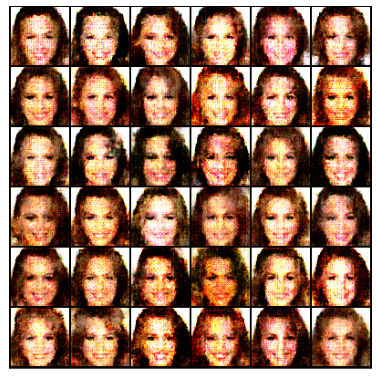

In [14]:
# Given a CelebA input
set_seed(3)

# Visualize the input
data = next(iter(dataloader_subset))
x = data[0].to(device)

grid_img = vutils.make_grid(x[0].view(1, 3, 64, 64).cpu().float(), nrow=1)
fig = plt.figure(figsize=(3, 3), dpi=40)
plt.imshow(grid_img.permute(1, 2, 0).detach().numpy())
plt.xticks([])
plt.yticks([])
plt.show()

# Visualize the samples from the induced functional prior
x_pred = sample_autoencoder_prior(x, encoder_prior, decoder_prior, 36)

grid_img = vutils.make_grid(x_pred[::32].view(x_pred[::32].shape, 3, 64, 64).cpu().float(), nrow=6)
fig = plt.figure(figsize=(8, 8), dpi=60)
plt.imshow(grid_img.permute(1, 2, 0).detach().numpy())
plt.xticks([])
plt.yticks([])
plt.show()

del x_pred
del x
torch.cuda.empty_cache()

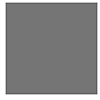

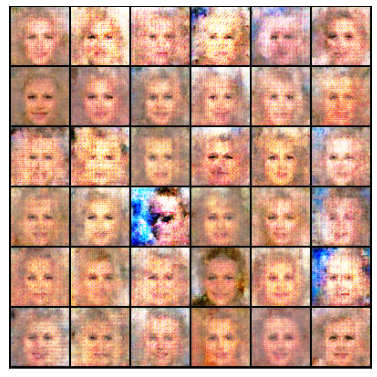

In [15]:
# Given a noisy input
# Visualize the input
data = next(iter(dataloader_subset))
x = data[0].to(device)
x = torch.ones_like(x) * (x.mean())
x = x.to(device) 

grid_img = vutils.make_grid(x[0].view(1, 3, 64, 64).cpu().float(), nrow=1)
fig = plt.figure(figsize=(3, 3), dpi=40)
plt.imshow(grid_img.permute(1, 2, 0).detach().numpy())
plt.xticks([])
plt.yticks([])
plt.show()

# Visualize the samples from the induced functional prior
x_pred = sample_autoencoder_prior(x, encoder_prior, decoder_prior, 36)

grid_img = vutils.make_grid(x_pred[::32].view(x_pred[::32].shape, 3, 64, 64).cpu().float(), nrow=6)
fig = plt.figure(figsize=(8, 8), dpi=60)
plt.imshow(grid_img.permute(1, 2, 0).detach().numpy())
plt.xticks([])
plt.yticks([])
plt.show()

del x_pred
del x
torch.cuda.empty_cache()

# Posterior

In [23]:
set_seed(123)

dataset = CelebA(root="../datasets")

test_loader = DataLoader(dataset.test, batch_size=100, shuffle=False,
                         num_workers=1, pin_memory=True)

## Initialize Bayesian Autoencoder with Optimized Prior

In [24]:
latent_size = 50

set_seed(123)

encoder_net = ConvNet(3, latent_size,
                  n_channels=[64, 128, 256, 512],
                  kernel_sizes=[5, 5, 5, 5],
                  strides=[2, 2, 2, 2],
                  paddings=[0, 0, 0, 0],
                  activation='leaky_relu',
                  in_lambda=None)

decoder_net = InvConvNet(
        latent_size, 3, n_hiddens=[8*8*512], n_channels=[512, 256, 128],
        kernel_sizes=[5, 5, 4],
        strides=[2, 2, 2],
        paddings=[2, 1, 0],
        activation='leaky_relu',
        mid_lambda=lambda x: x.view(x.shape[0], 512, 8, 8),
        out_lambda=lambda x: torch.sigmoid(x.view(x.shape[0], 3, 64, 64)))

encoder_net = encoder_net.to(device)
decoder_net = decoder_net.to(device)

encoder = encoder_net
decoder = ConditionalBernoulli(decoder_net)

model = BAE(encoder=encoder, decoder=decoder,
            encoder_prior=encoder_prior, decoder_prior=decoder_prior)

In [48]:
# Load the sampled parameters
RESULT_DIR = "../exp/conv_celeba/posterior_train_size_1000/"
SAMPLES_DIR = os.path.join(RESULT_DIR, "param_samples")

model.set_samples(SAMPLES_DIR, cache=True)

100%|██████████| 32/32 [00:01<00:00, 16.49it/s]


## Reconstruct Images

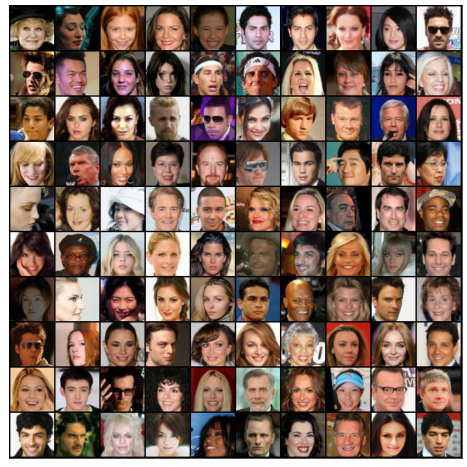

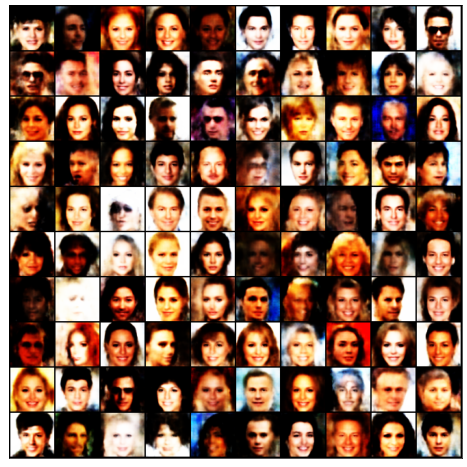

In [49]:
set_seed(SEED)


iterator = iter(test_loader)

model.eval()
with torch.no_grad():
    for _ in range(1):
        x = next(iterator)
    x = x.float().to(device)
    x_pred = model.predict(x, randomness=True)

grid_img = vutils.make_grid(x.view(x.shape[0], 3, 64, 64).cpu().float(), nrow=10)

fig = plt.figure(figsize=(10, 10), dpi=60)
plt.imshow(grid_img.permute(1, 2, 0).detach().numpy())
plt.xticks([])
plt.yticks([])
plt.show()

grid_img = vutils.make_grid(x_pred.view(x_pred.shape[0], 3, 64, 64).cpu().float(), nrow=10)

fig = plt.figure(figsize=(10, 10), dpi=60)
plt.imshow(grid_img.permute(1, 2, 0).detach().numpy())
plt.xticks([])
plt.yticks([])
plt.show()


## Generate Images

In [50]:
# Load the Dirichlet Process Mixture Model
set_seed(SEED)

density_estimator = DensityEstimator(method="gmm_dirichlet", n_components=20)
density_estimator.load_model(os.path.join(RESULT_DIR, "gmm_dirichlet.pkl"))
model.set_density_estimator(density_estimator)

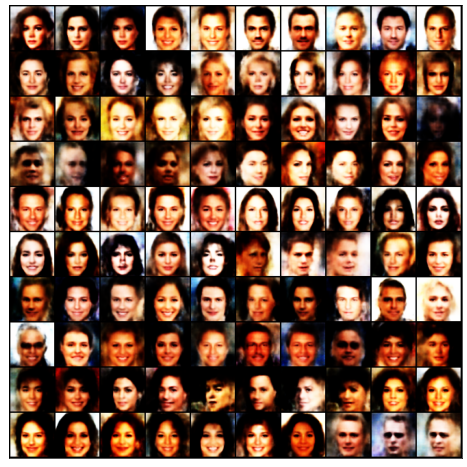

In [51]:
# Generate images
model.eval()
with torch.no_grad():
    samples = model.sample(100, randomness=True)
    grid_img = vutils.make_grid(samples.view(samples.shape[0], 3, 64, 64).cpu().float(), nrow=10)

    fig = plt.figure(figsize=(10, 10), dpi=60)
    plt.imshow(grid_img.permute(1, 2, 0).detach().numpy())
    plt.xticks([])
    plt.yticks([])
    plt.show()